In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


#######################Тут не все компании!!!######################################
#######################Тут не все компании!!!######################################
companies = ['SBER','GAZP' , 'LKOH', 'GMKN', 'MGNT',
       'TATN', 'NVTK', 'SNGS', 'PLZL', 'SNGSP',
       'PIKK', 'ROSN', 'SBERP', 'CHMF', 'NLMK',
       'IRAO', 'YNDX', 'ALRS', 'RUAL', 'MTSS',
       'MAGN', 'PHOR', 'RTKM', 'VTBR', 'TATNP',
       'TCSG', 'AGRO', 'AFLT', 'AFKS',
       'TRNFP', 'CBOM',
       'FIVE', 'MOEX',
       'HYDR']
companies = ['SBER', 'SBERP', 'VTBR', 'TATNP','TRNFP', 'MOEX']
######################Тут не все компании!!!##############################################
######################Тут не все компании!!!##############################################

/tmp/ipykernel_11160/3110112531.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)

In [3]:
# total_df.tradetime = total_df.close
# total_df.drop(['close', 'pr_close'], 1, inplace = True)
# total_df.rename(columns={'tradetime':'close'}, inplace=True)
# total_df = total_df.set_index('tradedate')

/tmp/ipykernel_26178/442606538.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  total_df.drop(['close', 'pr_close'], 1, inplace = True)


In [3]:
l = []
for i in companies:
    data = total_df[total_df['secid'] == i]
    l.append(data.shape[0])

max_len = min(l)
data = np.zeros((max_len, len(companies)))
for i, company in enumerate(companies):
    series = np.array(total_df[total_df.secid == company].close)[:max_len]
    data[:,i] += series

# max_len = 94740
# data = np.zeros((max_len, len(companies)))
# for i, company in enumerate(companies):
#     series = np.array(total_df[total_df.secid == company].close)[:max_len]
#     data[:,i] += series

In [4]:

train_data = data[ : round(data.shape[0]*0.80) ]
val_data = data[ round(data.shape[0]*0.80) : ]


# train_data = data[ : round(data.shape[0]*0.55) ]
# val_data = data[ round(data.shape[0]*0.60) : ]

In [5]:
for i in range(data.shape[1]):
    if i == 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
    
        scaler_star = StandardScaler()
        train_series = scaler_star.fit_transform(train_series)
        val_series = scaler_star.transform(val_series)
    
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()
    
    elif i != 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
        
        scaler = StandardScaler()
        train_series = scaler.fit_transform(train_series)
        val_series = scaler.transform(val_series)
        
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()

In [6]:
train_data1 = train_data[ : round(data.shape[0]*0.53) ]
train_data2 = train_data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ]

In [7]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    lookback=исторический промежуток
    horizon=горизонт прогнозирования
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [251]:
lookback = 50
horizon = 3


x_train1, y_train1 = sample_creator(train_data1, lookback, horizon)
x_train2, y_train2 = sample_creator(train_data2, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

x_train= torch.Tensor( np.concatenate([x_train1, x_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )

train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)                          


train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([5670, 50, 6]), y_train: torch.Size([5670, 3])
x_val: torch.Size([1530, 50, 6]), y_val: torch.Size([1530, 3])


In [253]:
def winrate_long(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign( np.diff(y_true) )
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res

In [254]:
import TSMixer.TSMixer_models as mix
print(mix.TSMixer.__doc__)


    seq_len = длина последовательности, на которую смотрит модель для прогноза
    num_features = количество признаков
    forecast_horizon = горизонт прогнозирвания
    dropout = коэффициент дропаута
    num_of_blocks = количество Mixer блоков в архитектуре
    


In [255]:
model = mix.TSMixer(lookback, len(companies), horizon, 0.2, 2).to(device)
model.load_state_dict(torch.load('ЧВЕСА/[50,6,3,0.2,2]TSMixer(M F=AS) ND|W=0.4905, TL=4.1089 VL=3.3302'))

<All keys matched successfully>

In [261]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, verbose=True)

epochs = 50
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate_long( y_batch.cpu().detach().numpy(), outputs.cpu().detach().numpy() )
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate_long( y_batch.cpu().detach().numpy(), outputs.cpu().detach().numpy() )
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    if val_loss < 0.00035:
        torch.save(model.state_dict(), f'ВЕСА/(4blocks)(6as)TSMixer(M F=AS) ND|W={val_win / len(val_loader)}, VL={val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 0.078354 Validation Loss: 0.001775


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 0.003188 Validation Loss: 0.000730


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.001707 Validation Loss: 0.000699


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.001225 Validation Loss: 0.000613


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.001162 Validation Loss: 0.000941


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 0.001055 Validation Loss: 0.000636


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.001082 Validation Loss: 0.000659


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 6.0000e-03.
Epoch 8 / 50,Train Loss: 0.001014 Validation Loss: 0.000799


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.000964 Validation Loss: 0.000571


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 0.000901 Validation Loss: 0.000555


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.000896 Validation Loss: 0.000564


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.000884 Validation Loss: 0.000560


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 50,Train Loss: 0.000904 Validation Loss: 0.000562


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 1.2000e-03.
Epoch 14 / 50,Train Loss: 0.000891 Validation Loss: 0.000572


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.000878 Validation Loss: 0.000552


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.000881 Validation Loss: 0.000556


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 50,Train Loss: 0.000881 Validation Loss: 0.000552


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 / 50,Train Loss: 0.000878 Validation Loss: 0.000563


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 2.4000e-04.
Epoch 19 / 50,Train Loss: 0.000875 Validation Loss: 0.000579


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 0.000887 Validation Loss: 0.000550


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 50,Train Loss: 0.000873 Validation Loss: 0.000552


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 50,Train Loss: 0.000872 Validation Loss: 0.000552


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 / 50,Train Loss: 0.000878 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 4.8000e-05.
Epoch 24 / 50,Train Loss: 0.000873 Validation Loss: 0.000552


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 / 50,Train Loss: 0.000869 Validation Loss: 0.000552


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 / 50,Train Loss: 0.000866 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 50,Train Loss: 0.000868 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00028: reducing learning rate of group 0 to 9.6000e-06.
Epoch 28 / 50,Train Loss: 0.000866 Validation Loss: 0.000552


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 / 50,Train Loss: 0.000867 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 / 50,Train Loss: 0.000870 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 50,Train Loss: 0.000870 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00032: reducing learning rate of group 0 to 1.9200e-06.
Epoch 32 / 50,Train Loss: 0.000873 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33 / 50,Train Loss: 0.000875 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34 / 50,Train Loss: 0.000871 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 50,Train Loss: 0.000870 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00036: reducing learning rate of group 0 to 3.8400e-07.
Epoch 36 / 50,Train Loss: 0.000867 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37 / 50,Train Loss: 0.000867 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38 / 50,Train Loss: 0.000870 Validation Loss: 0.000552


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 50,Train Loss: 0.000875 Validation Loss: 0.000551


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00040: reducing learning rate of group 0 to 7.6800e-08.
Early stopping!
Training complete in 0m 6s


In [16]:
# model = mix.TSMixer(lookback, len(companies), horizon, 0.3, 4).to(device)
# model.load_state_dict(torch.load('ВЕСА/(4blocks)(6as)TSMixer(M F=AS) ND|W=0.4820798599215864, VL=0.00035077138874031435[\'SBER\', \'SBERP\', \'VTBR\', \'TATNP\',\'TRNFP\', \'MOEX\']'))

In [262]:
# Evaluation
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)

In [263]:
winrate_long(y_val.numpy(), predictions1)

0.4977124183006536

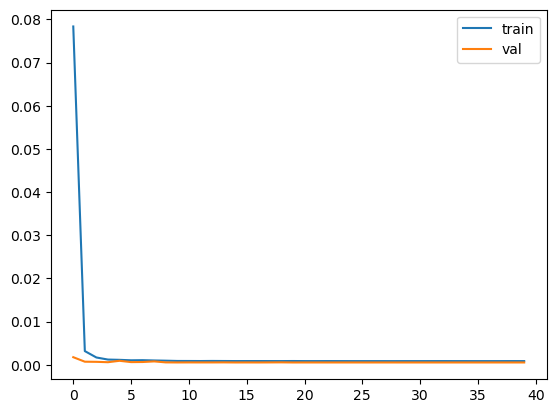

In [264]:
plt.plot(train_loss_per_epoch[:])
plt.plot(val_loss_per_epoch[:])
plt.legend(['train','val'])

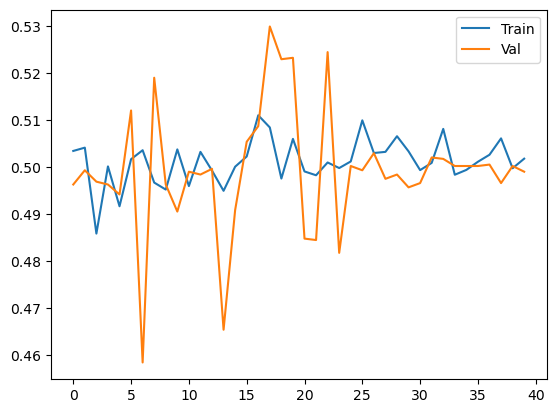

In [266]:
plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Train','Val'])

In [267]:
predictions1 = scaler_star.inverse_transform(predictions1)

In [268]:
y_val = scaler_star.inverse_transform(y_val)

In [269]:
criterion(torch.Tensor(predictions1),torch.Tensor(y_val)).item()

3.0681614875793457

In [270]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)

model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [271]:
winrate_long(y_train, predictions2)

0.5073192239858907

In [272]:
y_train = scaler_star.inverse_transform(y_train)

In [273]:
predictions2 = scaler_star.inverse_transform(predictions2)

In [274]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(4.7213)

In [276]:
torch.save(model.state_dict(), f'ЧВЕСА/[50,6,3,0.2,2]TSMixer(M F=AS) ND|W=0.4977, TL=3.7089 VL=3.9681' )